## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 21:47:27--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.8’

CreditScoring.csv.8 100%[===================>] 178,21K  --.-KB/s    in 0,03s   

2021-10-03 21:47:28 (5,19 MB/s) - ‘CreditScoring.csv.8’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('data/data-week4.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [5]:
df.nunique()

status          3
seniority      47
home            7
time           11
age            50
marital         6
records         2
job             5
expenses       94
income        353
assets        160
debt          183
amount        285
price        1419
dtype: int64

Some of the features are encoded as numbers. Use the following code to de-code them:

In [6]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)


marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)


records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)


job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

Prepare the numerical variables:

In [7]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [8]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [9]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

#### Explore the data

In [10]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [11]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [12]:
categorical = ['home', 'marital', 'records', 'job']
numerical = ['seniority', 'time', 'age', 'expenses','income', 'assets', 'debt', 'amount', 'price']
target = 'default'

#### Split the data into 3 parts:
train/validation/test with 60%/20%/20% distribution.

Use `train_test_split` function for that with `random_state=1`

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
y_bin = df['default'].values
del df['default']

In [15]:
df_train_full, df_test, \
y_train_full, y_test = train_test_split(df, y_bin, test_size=0.2, random_state=1)

df_train_full.shape, df_test.shape

((3563, 13), (891, 13))

In [16]:
df_train, df_valid,\
y_train, y_valid = train_test_split(df_train_full, y_train_full, test_size=df_test.shape[0], random_state=1)

df_train.shape, df_valid.shape, df_test.shape

((2672, 13), (891, 13), (891, 13))

In [17]:
df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

seniority 	 auc:0.709	 inverted: True
time      	 auc:0.561	 inverted: False
age       	 auc:0.573	 inverted: True
expenses  	 auc:0.501	 inverted: True
income    	 auc:0.682	 inverted: True
assets    	 auc:0.649	 inverted: True
debt      	 auc:0.505	 inverted: True
amount    	 auc:0.591	 inverted: False
price     	 auc:0.504	 inverted: False


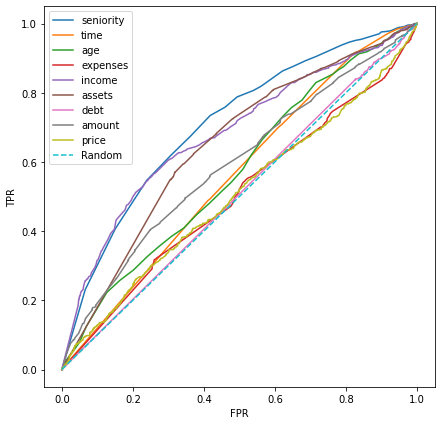

In [19]:
figure = plt.figure(figsize=[7,7])
auc_score = []

for n in numerical:
    ref = y_train
    against = df_train[n].values
    roc_score = roc_auc_score(ref, against)
    
    if roc_score < 0.5:
        against = -against
        
    # ROC score
    roc_score2 = roc_auc_score(ref, against)
        
    # ROC curve
    fpr, tpr, thresholds = roc_curve(ref, against)
    plt.plot(fpr, tpr, label=n)
    
    print(f"{n:10}\t auc:{roc_score2:.3f}\t inverted: {roc_score < 0.5}")
    
    auc_score.append((n, roc_score2))
    
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [20]:
sorted(auc_score, key=lambda x:x[1], reverse=True)[0]

('seniority', 0.7093778624491943)

> ANSWER: `seniority`

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [21]:
selected_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

#### One-hot encoding

In [22]:
from sklearn.feature_extraction import DictVectorizer

In [23]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[selected_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

#### train

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

#### predict

In [54]:
valid_dict = df_valid[selected_columns].to_dict(orient='records')
X_valid = dv.transform(valid_dict)

y_pred_proba = model.predict_proba(X_valid)

#y_pred = model.predict(X_valid)
y_pred = y_pred_proba[:, 1] >= 0.5

#### Accuracy

In [55]:
(y_valid == y_pred).mean()

0.7800224466891134

#### Precision & Recall

In [56]:
from sklearn.metrics import precision_score, recall_score

In [57]:
precision_score(y_valid, y_pred)

0.6404494382022472

In [58]:
recall_score(y_valid, y_pred)

0.4634146341463415

#### F1 score

In [59]:
from sklearn.metrics import f1_score

In [60]:
f1_score(y_valid, y_pred)

0.5377358490566039

#### ROC Score

In [61]:
from sklearn.metrics import roc_auc_score

In [62]:
roc_auc_score(y_valid, y_pred_proba[:, 1])

0.8120879813449298

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [63]:
# roc_auc_score(y_valid, y_pred).round(3) ### WRONG because y_pred is less precise than y_pred_proba

In [64]:
roc_auc_score(y_valid, y_pred_proba[:, 1]).round(3)

0.812

> ANSWER: `0.812`

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [65]:
thresholds_list = np.linspace(0,1.0,101)

#### get confusion matrix manually

In [66]:
t = 0.5
y_proba = y_pred_proba[:, 1]

predict_positive = y_proba >= t
predict_negative = y_proba < t

actual_positive = y_valid == 1
actual_negative = y_valid == 0

In [72]:
true_positive = (predict_positive & actual_positive).sum()
true_negative = (predict_negative & actual_negative).sum()

false_positive = (predict_positive & actual_negative).sum()
false_negative = (predict_negative & actual_positive).sum()

np.array([[true_negative, false_positive],[true_positive, false_negative]])

array([[581,  64],
       [114, 132]])

#### get confusion matrix with sklearn

In [73]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_valid, y_pred)

array([[581,  64],
       [132, 114]])

#### precision & recall

In [74]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

precision, recall

(0.6404494382022472, 0.4634146341463415)

#### search threshold manually

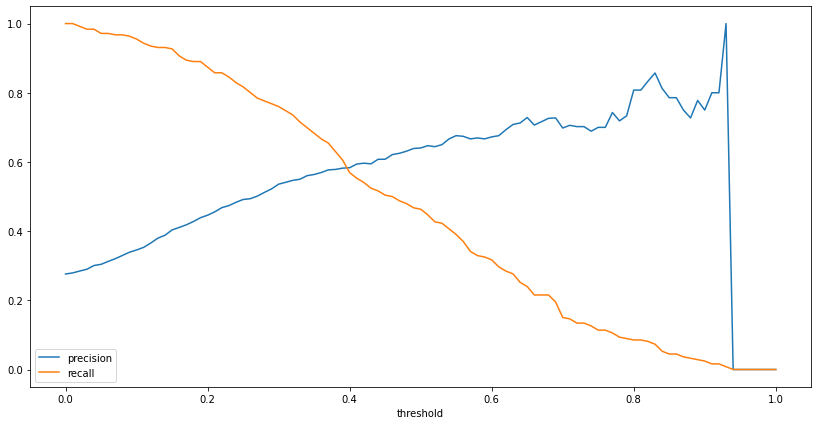

In [75]:
precisions = []
recalls = []

for t in thresholds_list:
    
    predict_positive = y_pred_proba[:,1] >= t
    predict_negative = y_pred_proba[:,1] < t
    actual_positive = y_valid == 1
    actual_negative = y_valid == 0
    
    true_positive = (predict_positive & actual_positive).sum()
    true_negative = (predict_negative & actual_negative).sum()
    false_positive = (predict_positive & actual_negative).sum()
    false_negative = (predict_negative & actual_positive).sum()
    
    #print(true_positive, true_negative, false_positive, false_negative)
    
    precision = 0
    if (true_positive + false_positive > 0):
        precision = true_positive / (true_positive + false_positive)
        
    recall = 0
    if (true_positive + false_negative > 0):
        recall = true_positive / (true_positive + false_negative)
    
    precisions.append(precision)
    recalls.append(recall)

    #print(f"{t:.2f} - accuracy: {accuracy:.2f} \t precision: {precision:.2f} \t recall: {recall:.2f}")
    
figure = plt.figure(figsize=[14,7])
plt.plot(thresholds_list, precisions, label="precision")
plt.plot(thresholds_list, recalls, label="recall")
plt.xlabel('threshold')
plt.legend()

#### search threshold with sklearn

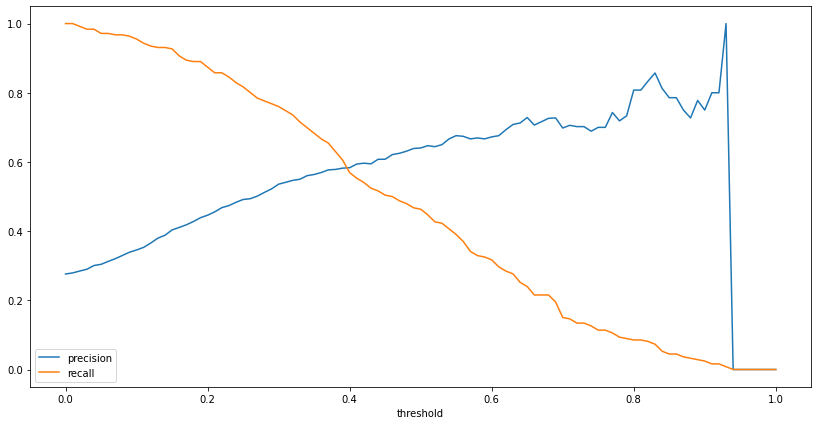

In [76]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

precisions = []
recalls = []

for t in thresholds_list:
    decision = y_pred_proba[:,1] >= t
    precision = precision_score(y_valid, decision, zero_division=0)
    recall = recall_score(y_valid, decision)
    
    precisions.append(precision)
    recalls.append(recall)

    #print(f"{t:.2f} - accuracy: {accuracy:.2f} \t precision: {precision:.2f} \t recall: {recall:.2f}")
    
figure = plt.figure(figsize=[14,7])
plt.plot(thresholds_list, precisions, label="precision")
plt.plot(thresholds_list, recalls, label="recall")
plt.xlabel('threshold')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

> ANSWER: `0.4`

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

#### F1 score manually

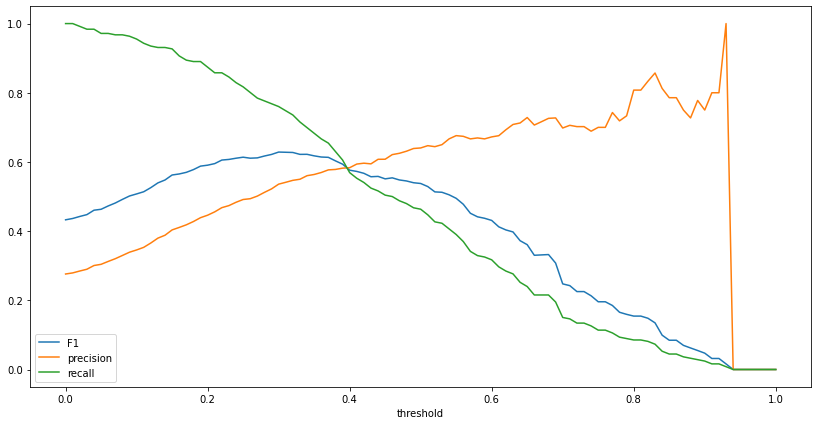

In [82]:
F1s = []
maxF1 = [None,0]
for t, P, R in zip(thresholds_list, precisions, recalls):
    
    F1 = 0
    if(P+R > 0):
        F1 = 2*(P*R)/(P+R)
    F1s.append(F1)
    
    if F1 > maxF1[1]:
        maxF1 = [t,F1]
    #print(f"{t} \t F1:{F1}")
   
figure = plt.figure(figsize=[14,7])
plt.plot(thresholds_list, F1s, label="F1")
plt.plot(thresholds_list, precisions, label="precision")
plt.plot(thresholds_list, recalls, label="recall")
plt.xlabel('threshold')
plt.legend()

In [83]:
print(f"max F1:{maxF1[1]}, threshold:{maxF1[0]}")

max F1:0.6285714285714286, threshold:0.3


#### F1 score with sklearn

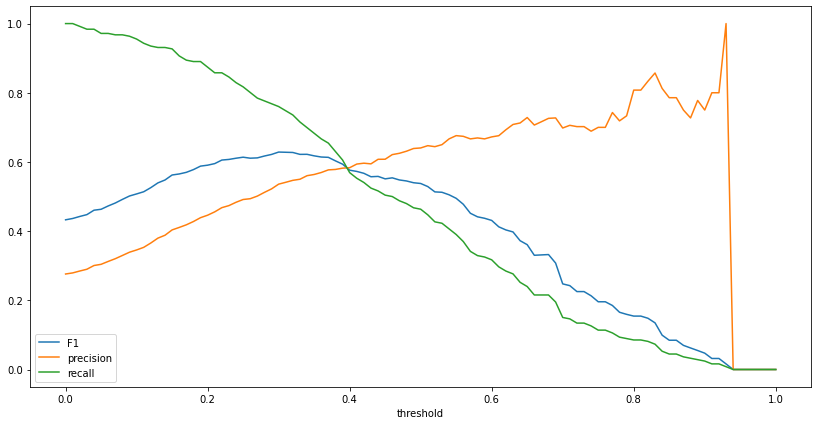

In [84]:
from sklearn.metrics import f1_score

F1s = []
maxF1 = [None,0]
for t, P, R in zip(thresholds_list, precisions, recalls):
    decision = y_pred_proba[:,1] >= t
    F1 = f1_score(y_valid, decision, zero_division=0)
    F1s.append(F1)
    
    if F1 > maxF1[1]:
        maxF1 = [t,F1]
    #print(f"{t} \t F1:{F1}")
   
figure = plt.figure(figsize=[14,7])
plt.plot(thresholds_list, F1s, label="F1")
plt.plot(thresholds_list, precisions, label="precision")
plt.plot(thresholds_list, recalls, label="recall")
plt.xlabel('threshold')
plt.legend()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [85]:
print(f"max F1:{maxF1[1]}, threshold:{maxF1[0]}")

max F1:0.6285714285714286, threshold:0.3


> ANSWER: `0.3`

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [86]:
from sklearn.model_selection import KFold

In [87]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
kf.get_n_splits()

5

In [88]:
dv = DictVectorizer(sparse=False)

train_full_dict = df_train_full[selected_columns].to_dict(orient='records')
X_train_full = dv.fit_transform(train_full_dict)

In [92]:
auc_scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_train_full)):
    
    X_train, X_valid = X_train_full[train_index], X_train_full[valid_index]
    y_train, y_valid = y_train_full[train_index], y_train_full[valid_index]
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    #y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)
    
    auc = roc_auc_score(y_valid, y_pred_proba[:, 1])
    auc_scores.append(auc)
    print(f"Fold {i+1} \t AUC: {auc:.3f}")

Fold 1 	 AUC: 0.826
Fold 2 	 AUC: 0.825
Fold 3 	 AUC: 0.789
Fold 4 	 AUC: 0.815
Fold 5 	 AUC: 0.805


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [93]:
np.array(auc_scores).std().round(3)

0.014

> ANSWER: `0.014`

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [94]:
for c in [0.01, 0.1, 1, 10]:
    
    auc_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(X_train_full)):

        X_train, X_valid = X_train_full[train_index], X_train_full[valid_index]
        y_train, y_valid = y_train_full[train_index], y_train_full[valid_index]

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        # y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)

        auc = roc_auc_score(y_valid, y_pred_proba[:, 1])
        auc_scores.append(auc)
    
    auc_scores = np.array(auc_scores)
    print(f"C: {c:5} \t Mean: {auc_scores.mean():.3f} \t Std: {auc_scores.std():.3f}")

C:  0.01 	 Mean: 0.809 	 Std: 0.013
C:   0.1 	 Mean: 0.813 	 Std: 0.014
C:     1 	 Mean: 0.812 	 Std: 0.014
C:    10 	 Mean: 0.814 	 Std: 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

> ANSWER: `10`